In [107]:
import executeQuery
from langchain_core.messages import HumanMessage, AIMessage
import os
from langchain_groq import ChatGroq
from dotenv import load_dotenv
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
import re
from langchain_core.tools import tool
from pydantic import BaseModel
import ast
from langchain_community.utilities import SQLDatabase
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage

load_dotenv()

model = ChatGroq(model="llama3-70b-8192")
db = SQLDatabase.from_uri(os.environ.get("DATABASE_URI"))

class UserDetails(BaseModel):
    CheckInDate: str = None
    CheckOutDate: str = None
    NumGuests: int = None
    GuestName: str = None
    Email: str = None
    PhoneNumber: int = None
    RoomType: str = None

def check_availability(CheckInDate: str, CheckOutDate: str, RoomType: str):
    """
    Check the availability of rooms for a specific type and dates.

    Args:
        CheckInDate (str): Check-in date.
        CheckOutDate (str): Check-out date.
        RoomType (str): Room type to check availability.

    Returns:
        str: Availability status message.
    """
    checkAvailabilityQuery = """
        SELECT r.RoomType, 
               r.TotalRooms - COALESCE(SUM(b.NumRooms), 0) AS AvailableRooms
        FROM Rooms r
        LEFT JOIN Bookings b
            ON r.RoomID = b.RoomID
            AND ((b.CheckInDate BETWEEN :check_in_date AND :check_out_date)
                OR (b.CheckOutDate BETWEEN :check_in_date AND :check_out_date)
                OR (b.CheckInDate <= :check_in_date AND b.CheckOutDate >= :check_out_date))
        WHERE r.RoomType = :room_type
        GROUP BY r.RoomID, r.RoomType, r.TotalRooms
        HAVING r.TotalRooms - COALESCE(SUM(b.NumRooms), 0) > 0;
    """

    try:
        # Run the query with parameters
        result = db.run(checkAvailabilityQuery, parameters={
            "check_in_date": "2025-04-01",
            "check_out_date": "2025-04-02",
            "room_type": "Deluxe Room"
        })
        
        result = ast.literal_eval(result)

        # Parse the result if available
        if result:
            available_rooms = result[0][1]  # Extract available rooms from the result
            if available_rooms <= 0:
                return "Sorry, this room is not available for your dates."
            else:
                return f"Room is available. {available_rooms} rooms left."
        else:
            return "No availability information found. Please try again."
    
    except Exception as e:
        return f"There was an error while checking the availability of the room: {str(e)}. Please check your details and get back to us. Thank you."
    
# def book_room(CheckInDate: str, CheckOutDate: str, NumGuests: int, GuestName: str, Email: str, PhoneNumber: int, RoomType: str, NumRooms: int):
@tool
def book_room():
    """
    Book a room by getting the following details from the user: {CheckInDate, CheckOutDate, NumGuests, GuestName, Email, PhoneNumber, RoomType, NumRooms}.
        
    Args:
        None
    Returns:
        str: A message indicating whether the hotel was successfully booked or not.
    """
    # CheckInDate: str = None
    # CheckOutDate: str = None
    # NumGuests: int = None
    # GuestName: str = None
    # Email: str = None
    # PhoneNumber: int = None
    # RoomType: str = None
    # NumRooms: int = None

    # booking the room
    query = """
        INSERT INTO Bookings (GuestName, Email, PhoneNumber, CheckInDate, CheckOutDate, RoomID, NumRooms, NumGuests, TotalAmount)
        VALUES (
            :GuestName,
            :Email,
            :PhoneNumber,
            :CheckInDate,
            :CheckOutDate,
            (SELECT RoomID FROM Rooms WHERE RoomType = :RoomType LIMIT 1),
            :NumRooms,
            :NumGuests,
            (SELECT PricePerNight * :NumRooms * (:check_out_date::DATE - :check_in_date::DATE)
            FROM Rooms WHERE RoomType = :room_type LIMIT 1)
        )
        RETURNING *;
    """

    try:
        fields = ["CheckInDate", "CheckOutDate", "NumGuests", "GuestName", "Email", "PhoneNumber", "RoomType", "NumRooms"]
        userDetails = {}

        print("Provide the following details: ")
        for i in fields:
            ip = i + ": "
            eachDetail = input(ip)
            userDetails[i] = eachDetail
        
        res = db.run(query, parameters=userDetails)

        if res:
            return "Room successfully booked."
        else:
            return "Booking could not be completed. Please check your details and try again."
    except Exception as e:
        return f"There was an error while booking the room: {str(e)}. Please check your details and get back to us. Thank you."

@tool
def cancel_room(BookingID: int):
    """
        Cancel a booking of room by using BoookingID.

        Args: 
            BookingID (int): ID of the booking of the room.

        return: Message telling that the booking has been successfully cancelled.
    """

    query = """
        DELETE FROM Bookings
        WHERE BookingID = :booking_id
        RETURNING *;
    """
    try:
        res = db.run(query, parameters={"booking_id": BookingID})
        if res:
            return "Booking successfully cancelled."
        else:
            return "No booking found with the provided ID."
    except Exception as e:
        return f"Error cancelling booking: {str(e)}"


In [108]:
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda

from langgraph.prebuilt import ToolNode


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

In [109]:
# State
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [110]:
# Agent
from langchain_groq import ChatGroq
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig
# import datetime
from datetime import datetime


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            configuration = config.get("configurable", {})
            passenger_id = configuration.get("passenger_id", None)
            state = {**state, "user_info": passenger_id}
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


# Haiku is faster and cheaper, but less accurate
# llm = ChatAnthropic(model="claude-3-haiku-20240307")
# llm = ChatAnthropic(model="claude-3-sonnet-20240229", temperature=1)
llm = ChatGroq(model="llama3-70b-8192")

# You could swap LLMs, though you will likely want to update the prompts when
# doing so!
# from langchain_openai import ChatOpenAI

# llm = ChatOpenAI(model="gpt-4-turbo-preview")

primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful customer support assistant for Swaroop Vilas Hotel. "
            "Use the provided tools to book a room, cancel booking, and other information to assist the user's queries. "
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)

part_1_tools = [
    book_room,
    cancel_room
]
part_1_assistant_runnable = primary_assistant_prompt | llm.bind_tools(part_1_tools)

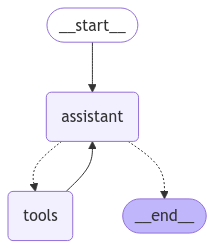

In [111]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)


# Define nodes: these do the work
builder.add_node("assistant", Assistant(part_1_assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(part_1_tools))
# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")

# The checkpointer lets the graph persist its state
# this is a complete memory for the entire graph.
memory = MemorySaver()
part_1_graph = builder.compile(checkpointer=memory)

from IPython.display import Image, display

try:
    display(Image(part_1_graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [112]:
import shutil
import uuid

# Let's create an example conversation a user might have with the assistant
tutorial_questions = [
    "Hi there, I want to book a room.",
]

# Update with the backup file so we can restart from the original place in each section
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}


_printed = set()

while True:
    question = input("You: ")
    
    if(question == "exit"):
        break
    events = part_1_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )

    for event in events:
        _print_event(event, _printed)


================================ Human Message =================================

book a room
================================== Ai Message ==================================
Tool Calls:
  book_room (call_348p)
 Call ID: call_348p
  Args:
Provide the following details: 
================================= Tool Message =================================
Name: book_room

There was an error while booking the room: (sqlalchemy.exc.InvalidRequestError) A value is required for bind parameter 'room_type'
[SQL: 
        INSERT INTO Bookings (GuestName, Email, PhoneNumber, CheckInDate, CheckOutDate, RoomID, NumRooms, NumGuests, TotalAmount)
        VALUES (
            %(GuestName)s,
            %(Email)s,
            %(PhoneNumber)s,
            %(CheckInDate)s,
            %(CheckOutDate)s,
            (SELECT RoomID FROM Rooms WHERE RoomType = %(RoomType)s LIMIT 1),
            %(NumRooms)s,
            %(NumGuests)s,
            (SELECT PricePerNight * %(NumRooms)s * (:check_out_date::DATE - :

KeyboardInterrupt: 